<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients', 'patients_summary', 'discharges_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

In [5]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [6]:
keys = ['contacts', 'querents', 'patients_summary', 'discharges_summary']

In [7]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,discharges_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,0,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,0,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...,...
2020-09-04 17:00:00+09:00,652,2027,136,0,2020-09-04 17:00:00+09:00
2020-09-05 17:00:00+09:00,824,1393,181,0,2020-09-05 17:00:00+09:00
2020-09-06 17:00:00+09:00,657,1327,116,0,2020-09-06 17:00:00+09:00
2020-09-07 17:00:00+09:00,799,2312,77,0,2020-09-07 17:00:00+09:00


In [8]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum
2020-09-04 17:00:00+09:00,652,2027,136,0,2020-09-04 17:00:00+09:00,729.428571,5106.0,1895.142857,13266.0,164.714286,1153.0,0.0,0.0
2020-09-05 17:00:00+09:00,824,1393,181,0,2020-09-05 17:00:00+09:00,727.714286,5094.0,1902.142857,13315.0,155.285714,1087.0,0.0,0.0
2020-09-06 17:00:00+09:00,657,1327,116,0,2020-09-06 17:00:00+09:00,712.428571,4987.0,1887.285714,13211.0,150.714286,1055.0,0.0,0.0
2020-09-07 17:00:00+09:00,799,2312,77,0,2020-09-07 17:00:00+09:00,714.428571,5001.0,1831.714286,12822.0,147.428571,1032.0,0.0,0.0
2020-09-08 17:00:00+09:00,0,0,170,0,2020-09-08 17:00:00+09:00,621.571429,4351.0,1572.714286,11009.0,147.428571,1032.0,0.0,0.0


In [9]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum,week_num,week_day
2020-08-25 17:00:00+09:00,626,1850,182,0,2020-08-25 17:00:00+09:00,754.428571,5281.0,1778.000000,12446.0,218.285714,1528.0,0.0,0.0,'20w35,Tue
2020-08-26 17:00:00+09:00,679,2092,236,0,2020-08-26 17:00:00+09:00,739.571429,5177.0,1811.428571,12680.0,225.428571,1578.0,0.0,0.0,'20w35,Wed
2020-08-27 17:00:00+09:00,708,2149,250,0,2020-08-27 17:00:00+09:00,733.000000,5131.0,1863.142857,13042.0,212.714286,1489.0,0.0,0.0,'20w35,Thu
2020-08-28 17:00:00+09:00,650,2179,226,0,2020-08-28 17:00:00+09:00,735.285714,5147.0,1913.000000,13391.0,208.142857,1457.0,0.0,0.0,'20w35,Fri
2020-08-29 17:00:00+09:00,836,1344,247,0,2020-08-29 17:00:00+09:00,722.714286,5059.0,1920.428571,13443.0,206.857143,1448.0,0.0,0.0,'20w35,Sat
2020-08-30 17:00:00+09:00,764,1431,148,0,2020-08-30 17:00:00+09:00,727.142857,5090.0,1947.857143,13635.0,197.714286,1384.0,0.0,0.0,'20w35,Sun
2020-08-31 17:00:00+09:00,785,2701,100,0,2020-08-31 17:00:00+09:00,721.142857,5048.0,1963.714286,13746.0,198.428571,1389.0,0.0,0.0,'20w36,Mon
2020-09-01 17:00:00+09:00,650,1813,170,0,2020-09-01 17:00:00+09:00,724.571429,5072.0,1958.428571,13709.0,196.714286,1377.0,0.0,0.0,'20w36,Tue
2020-09-02 17:00:00+09:00,710,1963,141,0,2020-09-02 17:00:00+09:00,729.000000,5103.0,1940.000000,13580.0,183.142857,1282.0,0.0,0.0,'20w36,Wed
2020-09-03 17:00:00+09:00,709,1987,211,0,2020-09-03 17:00:00+09:00,729.142857,5104.0,1916.857143,13418.0,177.571429,1243.0,0.0,0.0,'20w36,Thu


In [10]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [11]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-08-16 17:00:00+09:00,263.857143,1847
2020-08-23 17:00:00+09:00,231.285714,1619
2020-08-30 17:00:00+09:00,197.714286,1384
2020-09-06 17:00:00+09:00,150.714286,1055
2020-09-08 17:00:00+09:00,123.500000,247


In [12]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-08-25 17:00:00+09:00,626,1850,182,0,2020-08-25 17:00:00+09:00,754.428571,5281.0,1778.000000,12446.0,218.285714,1528.0,0.0,0.0,'20w35,Tue,NaN,NaN
2020-08-26 17:00:00+09:00,679,2092,236,0,2020-08-26 17:00:00+09:00,739.571429,5177.0,1811.428571,12680.0,225.428571,1578.0,0.0,0.0,'20w35,Wed,NaN,NaN
2020-08-27 17:00:00+09:00,708,2149,250,0,2020-08-27 17:00:00+09:00,733.000000,5131.0,1863.142857,13042.0,212.714286,1489.0,0.0,0.0,'20w35,Thu,NaN,NaN
2020-08-28 17:00:00+09:00,650,2179,226,0,2020-08-28 17:00:00+09:00,735.285714,5147.0,1913.000000,13391.0,208.142857,1457.0,0.0,0.0,'20w35,Fri,NaN,NaN
2020-08-29 17:00:00+09:00,836,1344,247,0,2020-08-29 17:00:00+09:00,722.714286,5059.0,1920.428571,13443.0,206.857143,1448.0,0.0,0.0,'20w35,Sat,NaN,NaN
2020-08-30 17:00:00+09:00,764,1431,148,0,2020-08-30 17:00:00+09:00,727.142857,5090.0,1947.857143,13635.0,197.714286,1384.0,0.0,0.0,'20w35,Sun,197.714286,1384.0
2020-08-31 17:00:00+09:00,785,2701,100,0,2020-08-31 17:00:00+09:00,721.142857,5048.0,1963.714286,13746.0,198.428571,1389.0,0.0,0.0,'20w36,Mon,NaN,NaN
2020-09-01 17:00:00+09:00,650,1813,170,0,2020-09-01 17:00:00+09:00,724.571429,5072.0,1958.428571,13709.0,196.714286,1377.0,0.0,0.0,'20w36,Tue,NaN,NaN
2020-09-02 17:00:00+09:00,710,1963,141,0,2020-09-02 17:00:00+09:00,729.000000,5103.0,1940.000000,13580.0,183.142857,1282.0,0.0,0.0,'20w36,Wed,NaN,NaN
2020-09-03 17:00:00+09:00,709,1987,211,0,2020-09-03 17:00:00+09:00,729.142857,5104.0,1916.857143,13418.0,177.571429,1243.0,0.0,0.0,'20w36,Thu,NaN,NaN


### グラフ出力

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

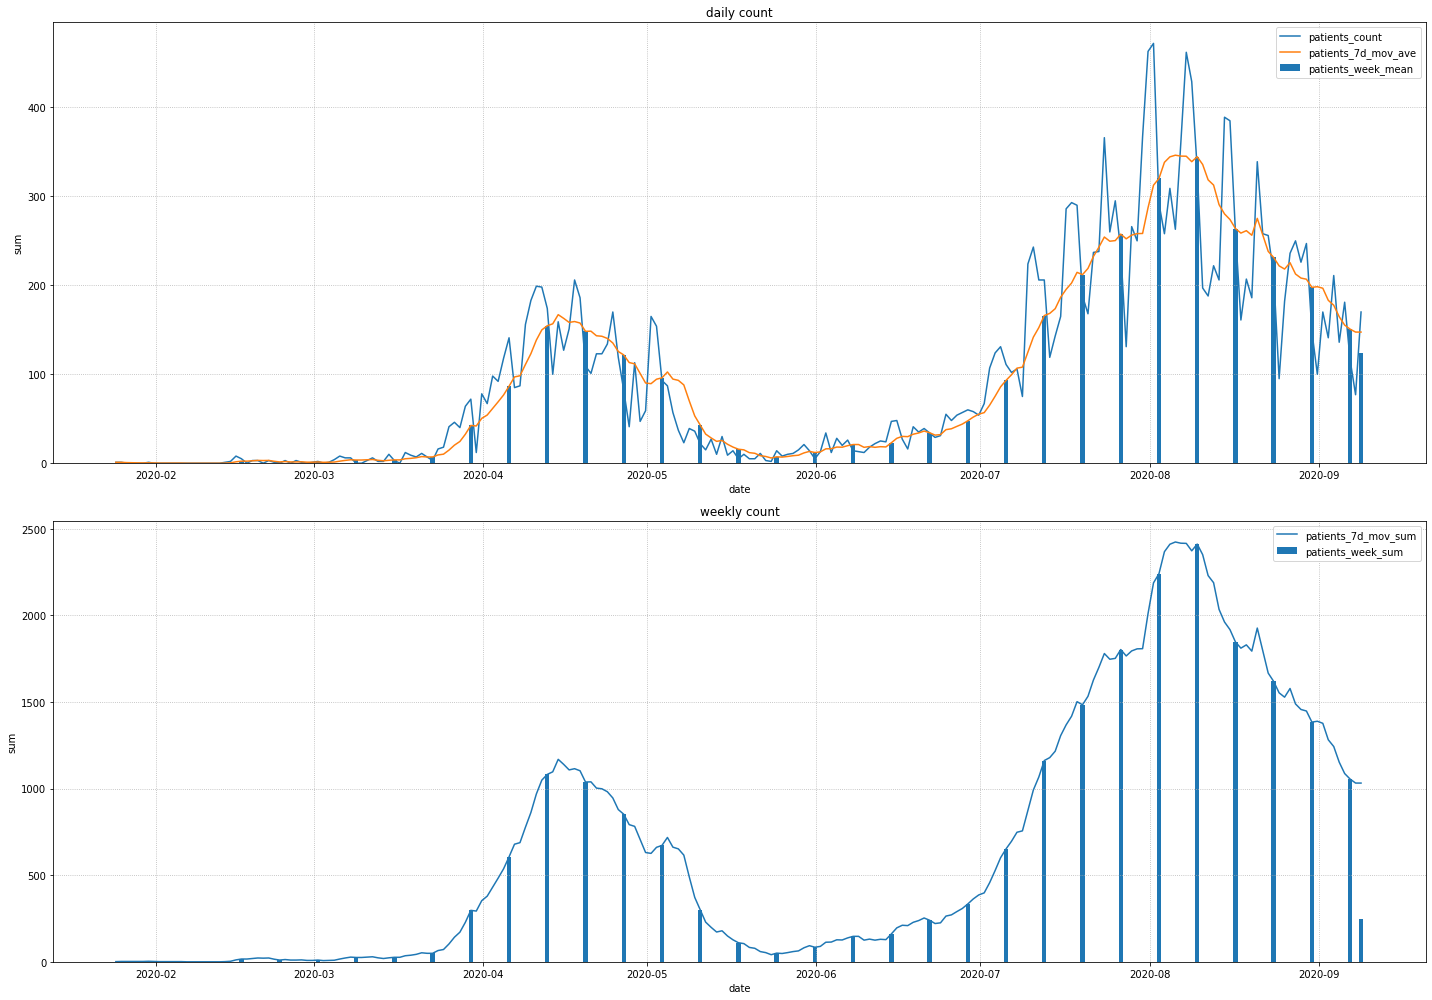

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
214,1.598342e+09,2020,8,25,0,0,0,0,0,1,0,214,0,140,626,754.428571,5281.0,1850,1778.000000,12446.0,182,218.285714,1528.0,0,0.0,0.0
215,1.598429e+09,2020,8,26,0,0,0,0,0,0,1,215,0,141,679,739.571429,5177.0,2092,1811.428571,12680.0,236,225.428571,1578.0,0,0.0,0.0
216,1.598515e+09,2020,8,27,0,0,0,0,1,0,0,216,0,142,708,733.000000,5131.0,2149,1863.142857,13042.0,250,212.714286,1489.0,0,0.0,0.0
217,1.598602e+09,2020,8,28,1,0,0,0,0,0,0,217,0,143,650,735.285714,5147.0,2179,1913.000000,13391.0,226,208.142857,1457.0,0,0.0,0.0
218,1.598688e+09,2020,8,29,0,0,1,0,0,0,0,218,0,144,836,722.714286,5059.0,1344,1920.428571,13443.0,247,206.857143,1448.0,0,0.0,0.0
219,1.598774e+09,2020,8,30,0,0,0,1,0,0,0,219,0,145,764,727.142857,5090.0,1431,1947.857143,13635.0,148,197.714286,1384.0,0,0.0,0.0
220,1.598861e+09,2020,8,31,0,1,0,0,0,0,0,220,0,146,785,721.142857,5048.0,2701,1963.714286,13746.0,100,198.428571,1389.0,0,0.0,0.0
221,1.598947e+09,2020,9,1,0,0,0,0,0,1,0,221,0,147,650,724.571429,5072.0,1813,1958.428571,13709.0,170,196.714286,1377.0,0,0.0,0.0
222,1.599034e+09,2020,9,2,0,0,0,0,0,0,1,222,0,148,710,729.000000,5103.0,1963,1940.000000,13580.0,141,183.142857,1282.0,0,0.0,0.0
223,1.599120e+09,2020,9,3,0,0,0,0,1,0,0,223,0,149,709,729.142857,5104.0,1987,1916.857143,13418.0,211,177.571429,1243.0,0,0.0,0.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              229 non-null    float64
 1   year                   229 non-null    int64  
 2   month                  229 non-null    int64  
 3   day                    229 non-null    int64  
 4   Fri                    229 non-null    uint8  
 5   Mon                    229 non-null    uint8  
 6   Sat                    229 non-null    uint8  
 7   Sun                    229 non-null    uint8  
 8   Thu                    229 non-null    uint8  
 9   Tue                    229 non-null    uint8  
 10  Wed                    229 non-null    uint8  
 11  passed                 229 non-null    int64  
 12  emergency              229 non-null    int64  
 13  em_passed              229 non-null    int64  
 14  contacts_count         229 non-null    int64  
 15  contac

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
count,2.290000e+02,229.0,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.0,229.0,229.0
mean,1.589702e+09,2020.0,5.026201,15.742358,0.144105,0.144105,0.144105,0.144105,0.139738,0.144105,0.139738,114.000000,0.213974,52.117904,859.087336,852.160220,5965.104803,1292.777293,1275.878977,8931.152838,96.152838,94.357018,660.427948,0.0,0.0,0.0
std,5.724068e+06,0.0,2.200322,9.050007,0.351965,0.351965,0.351965,0.351965,0.347474,0.351965,0.347474,66.250786,0.411007,51.609100,521.387623,508.862663,3562.066681,835.793177,641.054338,4487.380363,110.284513,102.920144,720.506164,0.0,0.0,0.0
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,1.584778e+09,2020.0,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,504.000000,498.571429,3490.000000,611.000000,924.428571,6471.000000,7.000000,6.857143,48.000000,0.0,0.0,0.0
50%,1.589702e+09,2020.0,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,114.000000,0.000000,40.000000,724.000000,713.428571,4994.000000,1295.000000,1205.142857,8436.000000,47.000000,43.000000,301.000000,0.0,0.0,0.0
75%,1.594627e+09,2020.0,7.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,171.000000,0.000000,97.000000,1182.000000,1189.571429,8327.000000,1850.000000,1756.428571,12295.000000,165.000000,159.285714,1115.000000,0.0,0.0,0.0
max,1.599552e+09,2020.0,9.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,228.000000,1.000000,154.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,472.000000,346.285714,2424.000000,0.0,0.0,0.0


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
timestamp,1.000000e+00,NaN,0.990876,-0.008083,-0.012414,0.006207,-0.006207,1.520624e-18,0.003048,0.012414,-0.003048,1.000000e+00,-0.126282,0.964519,0.331408,0.392319,0.392324,0.532245,0.739141,0.739141,0.682885,0.743045,0.743147,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,9.908758e-01,NaN,1.000000,-0.142606,-0.016224,0.006430,-0.004897,7.666645e-04,0.000927,0.012094,0.000927,9.908758e-01,-0.122623,0.953821,0.332457,0.391220,0.391225,0.530699,0.741619,0.741619,0.681317,0.738740,0.738855,NaN,NaN,NaN
day,-8.083277e-03,NaN,-0.142606,1.000000,0.029607,-0.002062,-0.010324,-4.816299e-03,0.015683,0.000691,-0.028948,-8.083277e-03,-0.002801,-0.002292,-0.015744,-0.003723,-0.003730,-0.018536,-0.061801,-0.061801,-0.042621,-0.029375,-0.029476,NaN,NaN,NaN
Fri,-1.241418e-02,NaN,-0.016224,0.029607,1.000000,-0.168367,-0.168367,-1.683673e-01,-0.165375,-0.168367,-0.165375,-1.241418e-02,-0.001854,-0.008908,-0.015843,-0.008389,-0.008387,0.062909,-0.010314,-0.010314,0.088581,-0.005457,-0.005519,NaN,NaN,NaN
Mon,6.207092e-03,NaN,0.006430,-0.002062,-0.168367,1.000000,-0.168367,-1.683673e-01,-0.165375,-0.168367,-0.165375,6.207092e-03,-0.001854,0.007029,0.047851,-0.000413,-0.000411,0.285003,0.003660,0.003660,-0.127235,0.000935,0.000949,NaN,NaN,NaN
Sat,-6.207092e-03,NaN,-0.004897,-0.010324,-0.168367,-0.168367,1.000000,-1.683673e-01,-0.165375,-0.168367,-0.165375,-6.207092e-03,-0.001854,-0.003595,0.035065,-0.005506,-0.005505,-0.333150,-0.006445,-0.006445,0.090841,-0.002343,-0.002389,NaN,NaN,NaN
Sun,1.520624e-18,NaN,0.000767,-0.004816,-0.168367,-0.168367,-0.168367,1.000000e+00,-0.165375,-0.168367,-0.165375,-6.682431e-19,-0.001854,0.001717,-0.013047,-0.003208,-0.003206,-0.302243,-0.002760,-0.002760,-0.020909,-0.000377,-0.000383,NaN,NaN,NaN
Thu,3.048394e-03,NaN,0.000927,0.015683,-0.165375,-0.165375,-0.165375,-1.653754e-01,1.000000,-0.165375,-0.162437,3.048394e-03,0.004694,-0.001657,0.004024,0.010330,0.010332,0.096913,0.008973,0.008973,0.062733,0.003557,0.003597,NaN,NaN,NaN
Tue,1.241418e-02,NaN,0.012094,0.000691,-0.168367,-0.168367,-0.168367,-1.683673e-01,-0.165375,1.000000,-0.165375,1.241418e-02,-0.001854,0.012341,-0.047989,-0.000413,-0.000411,0.114317,0.003660,0.003660,-0.038535,0.003863,0.003889,NaN,NaN,NaN


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum', 'discharges_count',
       'discharges_7d_mov_ave', 'discharges_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          'discharges_7d_mov_ave', 'discharges_7d_mov_sum'], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0,0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0,0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0,0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0,0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,1.599206e+09,1,0,0,0,0,0,0,224,0,150,652,2027,136,164.714286,1153.0,0
225,1.599293e+09,0,0,1,0,0,0,0,225,0,151,824,1393,181,155.285714,1087.0,0
226,1.599379e+09,0,0,0,1,0,0,0,226,0,152,657,1327,116,150.714286,1055.0,0
227,1.599466e+09,0,1,0,0,0,0,0,227,0,153,799,2312,77,147.428571,1032.0,0


In [26]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


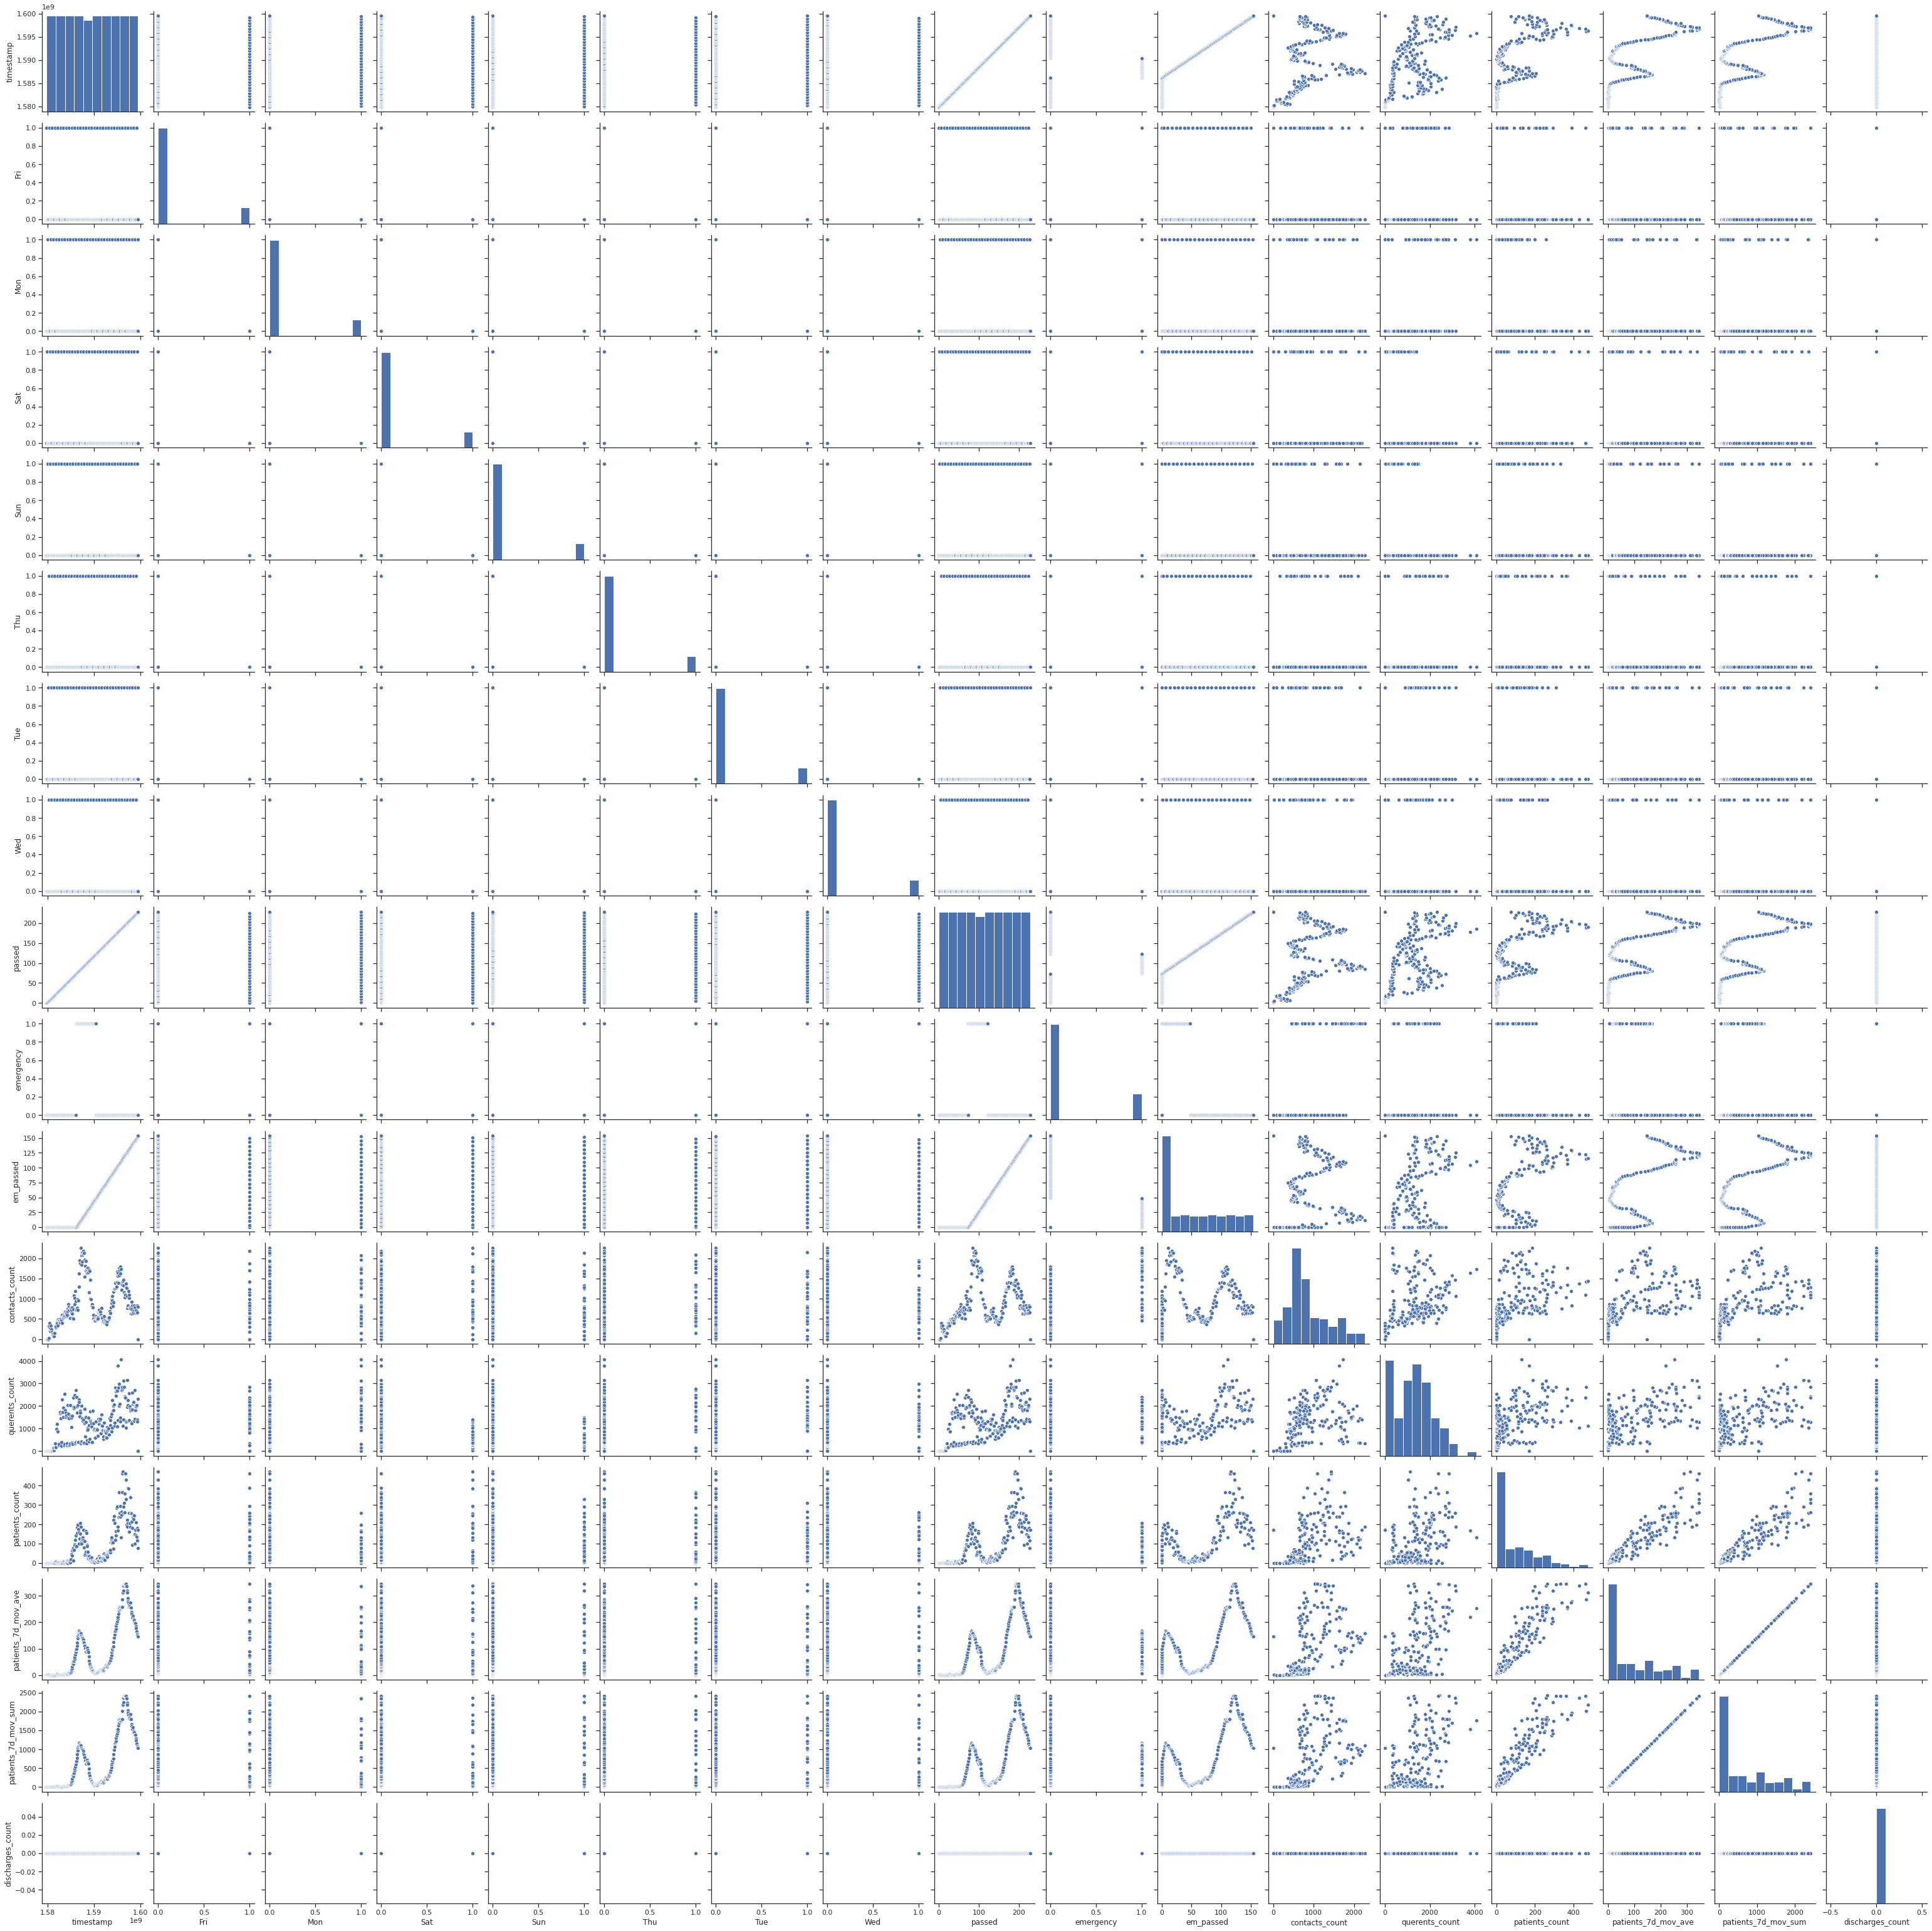

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df);

In [ ]:
!python -V

Python 3.6.9
